# Soil Power Sensor Calibraiton

This notebook allow for the calibration of soil power sensors (SPSs) and comparison between multiple SPSs. See the `README.md` file for instructions on running this Jupyter notebook. By default the data is stored within the `data` folder but can be changed with the `data_dir` variable. The `names` variable is a list of strings that specify what data to process and plot. File extensions are not specified as there is a `.csv` file to hold the raw measuremnts and a `.yaml` file that specifies the configuration settings of the board.

## CSV File

The *csv* file must have the following columns named as specified below. It is recomended to copy `template/template.csv` and rename to file to prevent any mistakes. Column `V_in` stores the voltage of the **IN**. Column `V_2x` stores the measurement from **Volt 2x Sense** header. Column `V_current` stores the current measurement from the **Current Sense** header. In terms of a equation `V_in` is the input and `V_2x` and `V_current` are the outputs. Fill the CSV file with measuremnts taken from the soil power sensor board. Ensure that the column of all rows are populated.

```
V_in,V_2x,V_current
```

## YAML File

The *YAML* file is used to specify the configuration of the soil power sensor board. Below is a copy from `template/template.yaml` with descriptions for each field. The fields `date` and `vcc` are currently not used in calculations but could prove to be useful for future comparisons.

```yaml
# Date the data was recorded
date: 2022-07-21
# Supply voltage in volts
vcc: 3.25
# Measured load resistor value in ohms
r_load: 2194
# Measured sensing resistor value in ohms
r_sense: 100
# Gain settings, valid options are [10, 100]
gain: 100
# Ref Select setting, valid options are ["bidirectional", "unidirection"]
ref: "unidirectional"
````

In [10]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [11]:
# Set plot size
factor = 1.2
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*factor

In [12]:
data_dir = "data"
names = ["sps1", "sps2", "sps3", "sps4"]

In [13]:
def calc_stats(x, y) -> dict:
    """Calculates linear resgression of data, fits the data, and calculates
    mae for pre and post calibration
    
    Parameters
    ----------
    x : input
    y : output
    
    Returns
    -------
    dict
        
    """
    
    linreg = stats.linregress(x, y)
    fit = linreg.intercept + x * linreg.slope
    mae_pre = abs(x-y).sum()/len(y)
    mae_post = abs(fit-y).sum()/len(y)
    
    r = {
        "slope": linreg.slope,
        "intercept": linreg.intercept,
        "rvalue": linreg.rvalue,
        "mae_pre": mae_pre,
        "mae_post": mae_post
    }
    
    return r

In [61]:
I_plots = []
V_plots = []

I_stats_list = []
V_stats_list = []

for n in names:
    # Get filepaths
    csv_path = os.path.join(data_dir, f"{n}.csv")
    yaml_path = os.path.join(data_dir, f"{n}.yaml")
    
    # Load configuration
    with open(yaml_path, "r") as f:
        config = yaml.load(f, Loader=Loader)
    
    # Load data
    data = pd.read_csv(csv_path)
    
    # Convert measured value to correct V/I measurements
    data["I_nom"] = data["V_in"] / config["r_load"] * 1e6
    data["I_calc"] = data["V_current"] / config["r_sense"] / config["gain"] * 1e6
    data["V_meas"] = data["V_2x"] / 2.
    
    
    # Calculate stats
    I_stats = calc_stats(data["I_calc"], data["I_nom"])
    I_stats["name"] = n
    V_stats = calc_stats(data["V_meas"], data["V_in"])
    V_stats["name"] = n
    
    I_stats_list.append(I_stats)
    V_stats_list.append(V_stats)
    
    # Generate a set of points for fit data
    data["I_fit"] = I_stats["intercept"] + I_stats["slope"] * data["V_meas"]
    data["V_fit"] = V_stats["intercept"] + V_stats["slope"] * data["I_calc"]
    
    I_plots.append(data[["I_nom", "I_calc", "I_fit"]])
    V_plots.append(data[["V_in", "V_meas", "V_fit"]])

## Statistics

Below is the computed voltage and current statistics for each of the SPSs. For each SPS linear regression is giving `slope`, `intercept`, and `rvalue`. Linear regression is preformed uinsg `y = intercept + slope * x`, where `x` is the nominal value and `y` is the calculated value. The `rvalue` is a indicate of how accurate the fit is. This value should be `> 0.99`, there may be a error in data collection otherwise. The mean average error for pre (`mae_pre`) and post (`mae_post`) is also calculated.

### Current Statistics

In [31]:
I_stats_df = pd.DataFrame(I_stats_list)
I_stats_df.set_index('name')

,slope,intercept,rvalue,mae_pre,mae_post
name,,,,,
sps1,1.053495,-0.215340,0.999997,8.481456,0.215408
sps2,1.047137,-0.108001,0.999995,7.616318,0.247936
sps3,1.049812,-0.604729,0.999945,7.494949,0.584517
sps4,1.048127,-0.120128,0.999997,7.680437,0.208992


### Voltage Statistics

In [32]:
V_stats_df = pd.DataFrame(V_stats_list)
V_stats_df.set_index('name')

,slope,intercept,rvalue,mae_pre,mae_post
name,,,,,
sps1,1.001275,-0.002944,0.999990,0.002463,0.000711
sps2,0.999700,-0.005534,0.999447,0.005650,0.004902
sps3,0.999629,-0.003393,0.999945,0.003534,0.001325
sps4,0.995695,-0.001860,0.999997,0.003491,0.000438


## Graphs

Below are the graphs that show the relative accuraccy of the current and voltage readings. On the y-axis is the soil power sensor's reading divided by the true input value. A perfect reading would result in 1. The x-axis is the input value.

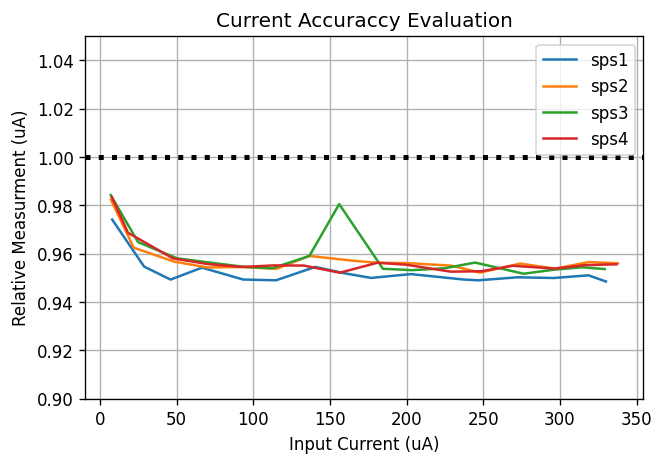

In [87]:
fig, ax = plt.subplots()

for n, i in zip(names, I_plots):
    ax.plot(i["I_nom"], i["I_calc"]/i["I_nom"], label=n)
    
ax.set_title("Current Accuraccy Evaluation")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurment (uA)")
# Scaling might have to be adjusted using the 'ymin' and 'ymax'
ax.axis(ymin=0.9,ymax=1.05)
ax.grid()
ax.legend()
ax.axhline(y=1, linestyle=':', color='k', linewidth='3')

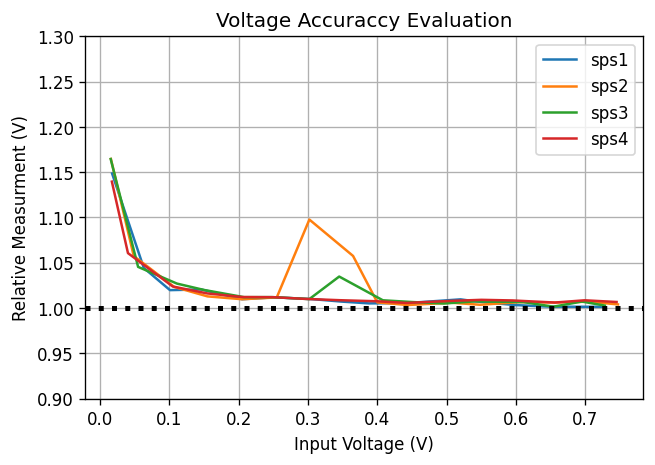

In [89]:
fig, ax = plt.subplots()

for n, v in zip(names, V_plots):
    ax.plot(v["V_in"], v["V_meas"]/v["V_in"], label=n)

ax.set_title("Voltage Accuraccy Evaluation")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurment (V)")
# Scaling might have to be adjusted using the 'ymin' and 'ymax'
ax.axis(ymin=0.9,ymax=1.3)
ax.grid()
ax.legend()
ax.axhline(y=1, linestyle=':', color='k', linewidth='3')